In [2]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import numpy             as np
import xarray            as xr
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import netCDF4
import yaml
import sys
import os
import pandas as pd

from   pylab             import cm
from   scipy             import ndimage
from numpy               import inf

NaN = np.nan
import warnings
warnings.filterwarnings("ignore")

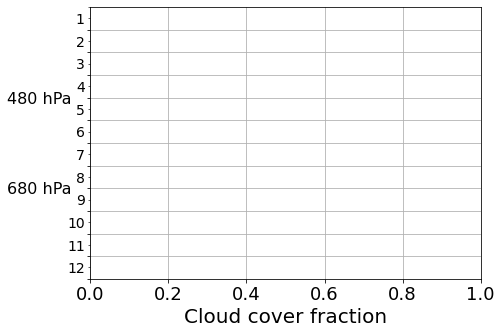

In [3]:
fig, ax = plt.subplots(1,1,figsize = (7,5))
import matplotlib.ticker as ticker

# a is an axes object, e.g. from figure.get_axes()

# Hide major tick labels
ax.yaxis.set_major_formatter(ticker.NullFormatter())

# Customize minor tick labels
y_minor = np.array(range(1,13))
ax.yaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.5,13,0.5)))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter(y_minor[::-1]))

ax.set_ylim(0,12)
ax.set_xlim(0,1)
ax.set_yticks(np.arange(0,12))
#ax.set_xticks(np.arange(0,1.2,0.2))
ax.set_yticklabels(['','','','','680 hPa','','','','480 hPa','','',''])
ax.tick_params(axis = 'x', labelsize=18)
ax.tick_params(axis = 'y', which='major', pad = 15, labelsize = 16)
ax.tick_params(axis='y', which='minor',labelsize = 14)

#ax.set_ylabel('Model Levels', fontsize = 20)
ax.set_xlabel('Cloud cover fraction',fontsize = 20)
ax.grid(axis = 'both')
plt.show()



# Fetching NetCDF files

In [21]:
#########################################################################
# Input arguments                                                       #
#########################################################################

working_directory = '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures'
YYYYi             = int(2014)
YYYYf             = int(2015)
period            = 'SON'
window            = int(25)
layerdef          = 'pmaxran'
#########################################################################
# Hardcoded values                                                      #
#########################################################################
if   period == 'annual': MMs = [1,2,3,4,5,6,7,8,9,10,11,12]
elif period == 'DJF'   : MMs = [ 1, 2,12]
elif period == 'MAM'   : MMs = [ 3, 4, 5]
elif period == 'JJA'   : MMs = [ 6, 7, 8]
elif period == 'SON'   : MMs = [ 9,10,11]
else                   : MMs = [ int(period) ] # single month

#########################################################################
# Configuration file (yml)                                              #
#########################################################################
yml_file = working_directory + '/config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)

dir_NetCDF = config['CALIPSOvsCOSP2vsGEM5_maps']['NetCDF'] +'/'+ layerdef

#if not os.path.exists(dir_png): os.makedirs(dir_png)

#########################################################################
# Main part                                                             #
#########################################################################

# Summing data (value and n for each level) from all the selected months
data_sum = {}
for YYYY in range(YYYYi,YYYYf+1):
    for MM in MMs:
        ncfile = '%s/%4d%02d.nc' % (dir_NetCDF,YYYY,MM)
        ds     = xr.open_dataset(ncfile)
        print(ncfile)
        for varname in ds.keys():
            if 'cloud_cover' in varname:
                if varname not in data_sum: data_sum[varname]  = ds[varname].values
                else                      : data_sum[varname] += ds[varname].values
            elif 'n_' in varname:
                if varname not in data_sum: data_sum[varname]  = ds[varname].values
                else                      : data_sum[varname] += ds[varname].values

/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran/201409.nc
/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran/201410.nc
/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran/201411.nc
/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran/201509.nc
/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran/201510.nc
/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP/NetCDF_HighMidLow_cloudcover_map/pmaxran/201511.nc


# LOADING GEM5 DOMAIN 

In [22]:
dpi = 150
data_dir = 'pampa/poitras/DATA'
### GEM path ###
pm                   = "pm2013010100"
gemname              = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes"
# Step 0 GEM path to set lat and lon in cartopy
step_0 = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes_step0"
ncfile = config['GEM5']['step0']

# Get lat, lon and cartopy_projection_object
ds  = xr.open_dataset(ncfile) # Dataframe from the netcdf file
lat = ds.lat.values           # 2D array with latitude
lon = ds.lon.values           # 2D array with longitude
m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude, ds.rotated_pole.grid_north_pole_latitude)
xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())

# Retreating unavailable data going 82º north to the upper domain
calipso_mask_82deg = np.where(np.array(ds['lat']) >= 82, np.nan,1)

# TEMPORAL (season) ----> SPATIAL (tracks to 2D maps) mean 

In [23]:
data_CALIPSO = []
data_GEM5    = []
data_COSP    = []
layer = ['t','h','m','l']
name  = ['Tot_cloud_cover_t', 'High_cloud_cover_h', 'Mid_cloud_cover_m', 'Low_cloud_cover_l' ]

for varname in name:
    
    varname_cloudcover_CALIPSO = 'calipso_' + varname
    varname_cloudcover_GEM5    = 'gem_'     + varname
    varname_cloudcover_COSP    = 'cosp_'    + varname
    varname_n                  = 'n_'       + layer[name.index(varname)]
    
    'Computing temoral mean: at this point we still to have only tracks'
    data_temporal_mean_CALIPSO = data_sum[varname_cloudcover_CALIPSO] / data_sum[varname_n]
    data_temporal_mean_GEM5    = data_sum[varname_cloudcover_GEM5  ]  / data_sum[varname_n]
    data_temporal_mean_COSP    = data_sum[varname_cloudcover_COSP  ]  / data_sum[varname_n]
    
    data_temporal_mean_CALIPSO[data_temporal_mean_CALIPSO == inf] = 1
    data_temporal_mean_GEM5   [data_temporal_mean_GEM5    == inf] = 1
    data_temporal_mean_COSP   [data_temporal_mean_COSP    == inf] = 1
    
    data_temporal_mean_CALIPSO[data_temporal_mean_CALIPSO > 1] = np.nan
    data_temporal_mean_GEM5   [data_temporal_mean_GEM5    > 1] = np.nan
    data_temporal_mean_COSP   [data_temporal_mean_COSP    > 1] = np.nan
    
    data_temporal_mean_CALIPSO = data_temporal_mean_CALIPSO 
    data_temporal_mean_GEM5    = data_temporal_mean_GEM5   
    data_temporal_mean_COSP    = data_temporal_mean_COSP   

    'Computing spatial mean over a square of size window x window'
    data_spatial_mean_CALIPSO   = ndimage.generic_filter(data_temporal_mean_CALIPSO, np.nanmean, size=window, mode='constant',cval=np.nan)
    data_spatial_mean_GEM5      = ndimage.generic_filter(data_temporal_mean_GEM5   , np.nanmean, size=window, mode='constant',cval=np.nan) 
    data_spatial_mean_COSP      = ndimage.generic_filter(data_temporal_mean_COSP   , np.nanmean, size=window, mode='constant',cval=np.nan) 

    data_CALIPSO.append(data_spatial_mean_CALIPSO * calipso_mask_82deg)
    data_GEM5.append(   data_spatial_mean_GEM5    * calipso_mask_82deg)
    data_COSP.append(   data_spatial_mean_COSP    * calipso_mask_82deg)

# EMPTY ARRAYS TO DO SEASONAL BAR PLOT

In [7]:
########################################
###              BIAS                ###
########################################
# GEM5 - MODIS
GEM5_bias_t   = []
GEM5_bias_h   = []
GEM5_bias_m   = []
GEM5_bias_l   = []

# COSP2 - MODIS
COSP_bias_t  = []
COSP_bias_h  = []
COSP_bias_m  = []
COSP_bias_l  = []

########################################
###               RMS                ###
########################################
# GEM5 - MODIS
GEM5_RMS_t   = []
GEM5_RMS_h   = []
GEM5_RMS_m   = []
GEM5_RMS_l   = []

# COSP2 - MODIS
COSP_RMS_t  = []
COSP_RMS_h  = []
COSP_RMS_m  = []
COSP_RMS_l  = []

########################################
###  CALIPSO seasonal cloud fraction ###
########################################
CAL_CF_t    = []
CAL_CF_h    = []
CAL_CF_m    = []
CAL_CF_l    = []

In [24]:
g_bias_t = np.subtract(data_GEM5[0], data_CALIPSO[0])
g_bias_h = np.subtract(data_GEM5[1], data_CALIPSO[1])
g_bias_m = np.subtract(data_GEM5[2], data_CALIPSO[2])
g_bias_l = np.subtract(data_GEM5[3], data_CALIPSO[3])

c_bias_t = np.subtract(data_COSP[0], data_CALIPSO[0])
c_bias_h = np.subtract(data_COSP[1], data_CALIPSO[1])
c_bias_m = np.subtract(data_COSP[2], data_CALIPSO[2])
c_bias_l = np.subtract(data_COSP[3], data_CALIPSO[3])

g_RE_t = np.subtract(data_GEM5[0], data_CALIPSO[0])/np.add(data_GEM5[0], data_CALIPSO[0])
g_RE_h = np.subtract(data_GEM5[1], data_CALIPSO[1])/np.add(data_GEM5[1], data_CALIPSO[1])
g_RE_m = np.subtract(data_GEM5[2], data_CALIPSO[2])/np.add(data_GEM5[2], data_CALIPSO[2])
g_RE_l = np.subtract(data_GEM5[3], data_CALIPSO[3])/np.add(data_GEM5[3], data_CALIPSO[3])

c_RE_t = np.subtract(data_COSP[0], data_CALIPSO[0])/np.add(data_COSP[0], data_CALIPSO[0])
c_RE_h = np.subtract(data_COSP[1], data_CALIPSO[1])/np.add(data_COSP[1], data_CALIPSO[1])
c_RE_m = np.subtract(data_COSP[2], data_CALIPSO[2])/np.add(data_COSP[2], data_CALIPSO[2])
c_RE_l = np.subtract(data_COSP[3], data_CALIPSO[3])/np.add(data_COSP[3], data_CALIPSO[3])

print(np.nanmax(c_RE_m))
print(np.nanmin(c_RE_m))

def RMS(bias):
    return np.sqrt(np.nansum(bias**2)/len(bias)**2)

# Generating array
print('Period :', period)
GEM5_bias_t.append(np.nanmean(g_bias_t));GEM5_bias_h.append(np.nanmean(g_bias_h));GEM5_bias_m.append(np.nanmean(g_bias_m));GEM5_bias_l.append(np.nanmean(g_bias_l))
COSP_bias_t.append(np.nanmean(c_bias_t));COSP_bias_h.append(np.nanmean(c_bias_h));COSP_bias_m.append(np.nanmean(c_bias_m));COSP_bias_l.append(np.nanmean(c_bias_l))

GEM5_RMS_t.append(RMS(g_bias_t));GEM5_RMS_h.append(RMS(g_bias_h));GEM5_RMS_m.append(RMS(g_bias_m));GEM5_RMS_l.append(RMS(g_bias_l))
COSP_RMS_t.append(RMS(c_bias_t));COSP_RMS_h.append(RMS(c_bias_h));COSP_RMS_m.append(RMS(c_bias_m));COSP_RMS_l.append(RMS(c_bias_l))

CAL_CF_t.append(np.nanmean(data_CALIPSO[0]));CAL_CF_h.append(np.nanmean(data_CALIPSO[1]));CAL_CF_m.append(np.nanmean(data_CALIPSO[2]));CAL_CF_l.append(np.nanmean(data_CALIPSO[3]))


print('BIAS COSP')
print('Total : ',np.nanmean(c_bias_t)*100)
print('High  : ',np.nanmean(c_bias_h)*100)
print('Mid   : ',np.nanmean(c_bias_m)*100)
print('Low   : ',np.nanmean(c_bias_l)*100)
print('###########################')
print('BIAS GEM5')
print('Total : ',np.nanmean(g_bias_t)*100)
print('High  : ',np.nanmean(g_bias_h)*100)
print('Mid   : ',np.nanmean(g_bias_m)*100)
print('Low   : ',np.nanmean(g_bias_l)*100)
print('###########################')
print('RMS COSP')
print('Total : ',RMS(c_bias_t))
print('High  : ',RMS(c_bias_h))
print('Mid   : ',RMS(c_bias_m))
print('Low.  : ',RMS(c_bias_l))
print('###########################')
print('RMS GEM5')
print('Total : ',RMS(g_bias_t))
print('High  : ',RMS(g_bias_h))
print('Mid   : ',RMS(g_bias_m))
print('Low   : ',RMS(g_bias_l))

print('###########################')
print('CALIPSO CF')
print('Total : ',np.nanmean(data_CALIPSO[0]))
print('High  : ',np.nanmean(data_CALIPSO[1]))
print('Mid   : ',np.nanmean(data_CALIPSO[2]))
print('Low   : ',np.nanmean(data_CALIPSO[3]))


0.8810700678182931
-1.0
Period : SON
BIAS COSP
Total :  -4.076295871315428
High  :  1.2609605875101448
Mid   :  -16.502785663218653
Low   :  -12.194770841727294
###########################
BIAS GEM5
Total :  -1.9180298785276761
High  :  -0.7394143567695766
Mid   :  -3.860039839457957
Low   :  5.454378277369942
###########################
RMS COSP
Total :  0.13529883035737145
High  :  0.14462918880574038
Mid   :  0.1801467182623308
Low.  :  0.1435391281056426
###########################
RMS GEM5
Total :  0.13074845857918
High  :  0.1641379850784196
Mid   :  0.08159488854962675
Low   :  0.14479791645712203
###########################
CALIPSO CF
Total :  0.7258123870113367
High  :  0.4367347353897933
Mid   :  0.27296134318185866
Low   :  0.38868005725981786


In [25]:
data_GEM5_bias = np.array([GEM5_bias_t, GEM5_bias_h, GEM5_bias_m, GEM5_bias_l ])
data_COSP_bias = np.array([COSP_bias_t, COSP_bias_h, COSP_bias_m, COSP_bias_l])

data_GEM5_rms  = np.array([GEM5_RMS_t  , GEM5_RMS_h , GEM5_RMS_m , GEM5_RMS_l ])
data_COSP_rms  = np.array([COSP_RMS_t  , COSP_RMS_h , COSP_RMS_m , COSP_RMS_l])

data_CAL_CF  = np.array([CAL_CF_t, CAL_CF_h, CAL_CF_m, CAL_CF_l])

print(data_CAL_CF)

[[0.69291962 0.68084358 0.72239603 0.72581239]
 [0.41388301 0.39707927 0.42798227 0.43673474]
 [0.28501211 0.26915282 0.25742974 0.27296134]
 [0.38609867 0.38530339 0.3699573  0.38868006]]


In [28]:
data_bias = {'Diagnostic':['t_CRCM6','t_COSP2','h_CRCM6','h_COSP2','m_CRCM6','m_COSP2','l_CRCM6','l_COSP2'],
        'DJF':[GEM5_bias_t[0],COSP_bias_t[0], GEM5_bias_h[0],COSP_bias_h[0],GEM5_bias_m[0],COSP_bias_m[0],GEM5_bias_l[0],COSP_bias_l[0]],
        'MAM':[GEM5_bias_t[1],COSP_bias_t[1], GEM5_bias_h[1],COSP_bias_h[1],GEM5_bias_m[1],COSP_bias_m[1],GEM5_bias_l[1],COSP_bias_l[1]],
        'JJA':[GEM5_bias_t[2],COSP_bias_t[2], GEM5_bias_h[2],COSP_bias_h[2],GEM5_bias_m[2],COSP_bias_m[2],GEM5_bias_l[2],COSP_bias_l[2]],
        'SON':[GEM5_bias_t[3],COSP_bias_t[3], GEM5_bias_h[3],COSP_bias_h[3],GEM5_bias_m[3],COSP_bias_m[3],GEM5_bias_l[3],COSP_bias_l[3]]}

data_RMSE = {'Diagnostic':['t_CRCM6','t_COSP2','h_CRCM6','h_COSP2','m_CRCM6','m_COSP2','l_CRCM6','l_COSP2'],
        'DJF':[GEM5_RMS_t[0],COSP_RMS_t[0], GEM5_RMS_h[0],COSP_RMS_h[0],GEM5_RMS_m[0],COSP_RMS_m[0],GEM5_RMS_l[0],COSP_RMS_l[0]],
        'MAM':[GEM5_RMS_t[1],COSP_RMS_t[1], GEM5_RMS_h[1],COSP_RMS_h[1],GEM5_RMS_m[1],COSP_RMS_m[1],GEM5_RMS_l[1],COSP_RMS_l[1]],
        'JJA':[GEM5_RMS_t[2],COSP_RMS_t[2], GEM5_RMS_h[2],COSP_RMS_h[2],GEM5_RMS_m[2],COSP_RMS_m[2],GEM5_RMS_l[2],COSP_RMS_l[2]],
        'SON':[GEM5_RMS_t[3],COSP_RMS_t[3], GEM5_RMS_h[3],COSP_RMS_h[3],GEM5_RMS_m[3],COSP_RMS_m[3],GEM5_RMS_l[3],COSP_RMS_l[3]]}

print(data_CAL_CF[:,0].tolist())
data_CF = {'Diagnostic':['Total','High','Mid','Low'],
                      'DJF':data_CAL_CF[:,0].tolist(),
                      'MAM':data_CAL_CF[:,1].tolist(),
                      'JJA':data_CAL_CF[:,2].tolist(),
                      'SON':data_CAL_CF[:,3].tolist()}

df_bias = pd.DataFrame(data_bias)
df_rms = pd.DataFrame(data_RMSE)
df_CF = pd.DataFrame(data_CF)

df_bias.set_index(['Diagnostic','DJF','MAM','JJA','SON'])
df_rms.set_index( ['Diagnostic','DJF','MAM','JJA','SON'])
df_CF.set_index( ['Diagnostic','DJF','MAM','JJA','SON'])

df_bias.to_excel("Seasonal_bias.xlsx") 
df_rms.to_excel("Seasonal_RMSE.xlsx")
df_CF.to_excel("Seasonal_CAL_CF.xlsx") 

[0.6929196198279807, 0.4138830063948317, 0.28501211487637396, 0.38609867060033837]


# CALIPSO, GEM5 & COSP2 Maps

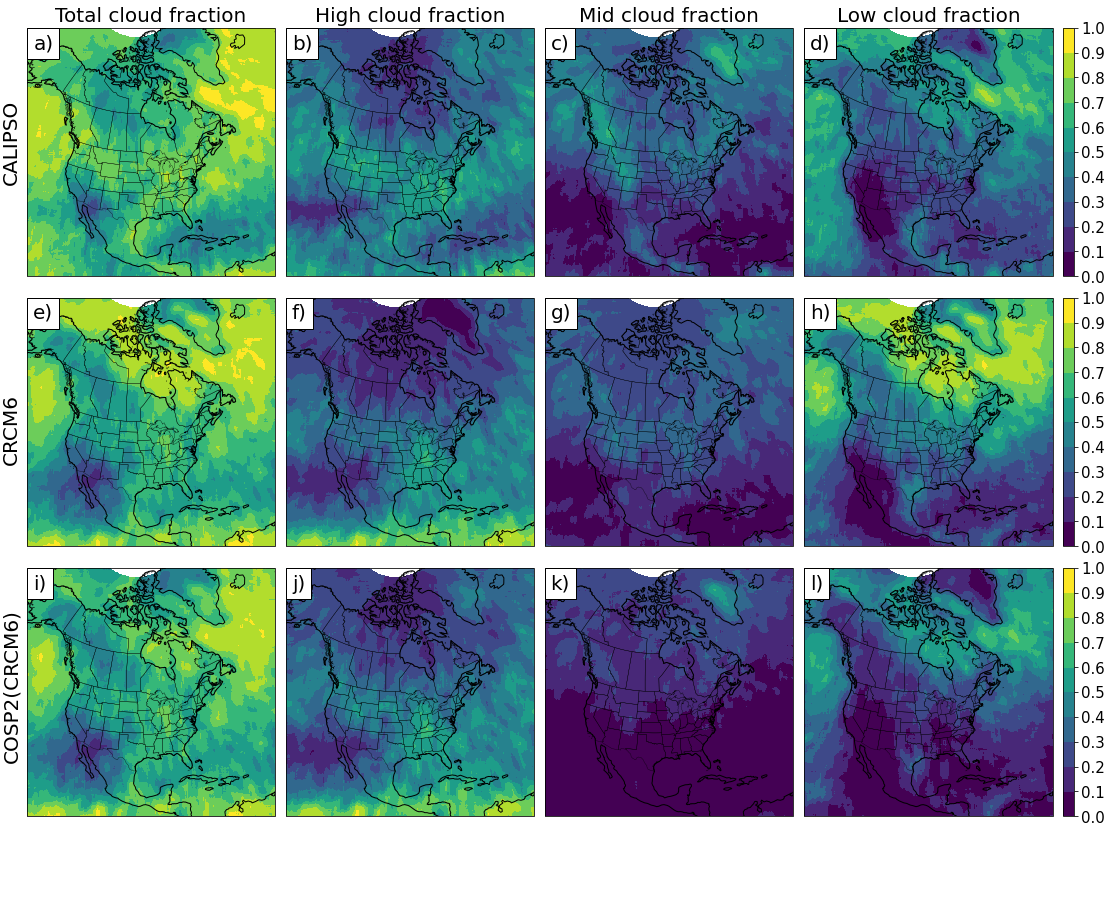

In [65]:
fig = plt.figure(figsize=(15, 15), constrained_layout = True)
vext = [0,1]
##########################################################################################################
###                                    Creating a discrete colorbar                                    ###
##########################################################################################################
# define the colormap                                                                                  ###
cmap_maps     = plt.cm.viridis                                                                         ###
# extract all colors from the .jet map                                                                 ###
cmaplist_maps = [cmap_maps(i) for i in range(cmap_maps.N)]                                             ###
# Colormap                                                                                             ###
cm            = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_maps, cmap_maps.N)###
# Colobar with values from 0 to 1 with 11 discrete colors                                              ###
bounds_maps  = np.linspace(0, 1, 11)                                                                   ###                                                                                            ###
norm_maps    = mpl.colors.BoundaryNorm(bounds_maps, cmap_maps.N)                                       ###
##########################################################################################################

L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
#############################
###        MODIS          ###
#############################

###########################################################################
l1 = 0.02; l2 = 0.26; l3 = 0.50 ;l4= 0.74                               ### 
h  = 0.23; w  = 0.23 # h = height, w = width of the subplots (fraction) ###
b  = 0.73            # b = bottom height                                ###
fs = 13              # Fontsize for titles                              ###
###########################################################################
# First subplot
ax1 = plt.axes([l1, b, w, h],projection=m)
ax1.set_extent([xll, xur, yll, yur], crs = m)
ax1.set_title('Total cloud fraction', fontsize = 20)
ax1.coastlines()
ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
MODIS_t = ax1.pcolormesh(lon, lat,data_CALIPSO[0], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Second subplot
ax2 = plt.axes([l2, b, w, h],projection=m)
ax2.set_extent([xll, xur, yll, yur], crs = m)
ax2.set_title('High cloud fraction', fontsize = 20)
ax2.coastlines()
ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax2.pcolormesh(lon, lat,data_CALIPSO[1], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Third subplot
ax3 = plt.axes([l3, b, w, h],projection=m)
ax3.set_extent([xll, xur, yll, yur], crs = m)
ax3.set_title('Mid cloud fraction', fontsize = 20)
ax3.coastlines()
ax3.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax3.pcolormesh(lon, lat,data_CALIPSO[2], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Fourth subplot
ax4 = plt.axes([l4, b, w, h],projection=m)
ax4.set_extent([xll, xur, yll, yur], crs = m)
ax4.set_title('Low cloud fraction', fontsize = 20)
ax4.coastlines()
ax4.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax4.pcolormesh(lon, lat,data_CALIPSO[3], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

###########################
###         GEM5        ###
###########################
b = 0.48
# First subplot
ax5 = plt.axes([l1, b, w, h],projection=m)
ax5.set_extent([xll, xur, yll, yur], crs = m)
#ax5.set_title('Total Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax5.coastlines()
ax5.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
GEM_t = ax5.pcolormesh(lon, lat,data_GEM5[0], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Second subplot
ax6 = plt.axes([l2, b, w, h],projection=m)
ax6.set_extent([xll, xur, yll, yur], crs = m)
#ax6.set_title('High Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax6.coastlines()
ax6.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax6.pcolormesh(lon, lat,data_GEM5[1], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Third subplot
ax7 = plt.axes([l3, b, w, h],projection=m)
ax7.set_extent([xll, xur, yll, yur], crs = m)
#ax7.set_title('Mid Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax7.coastlines()
ax7.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax7.pcolormesh(lon, lat,data_GEM5[2], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Fourth subplot
ax8 = plt.axes([l4, b, w, h],projection=m)
ax8.set_extent([xll, xur, yll, yur], crs = m)
#ax8.set_title('Low Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax8.coastlines()
ax8.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax8.pcolormesh(lon, lat,data_GEM5[3], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

###########################
###        COSP2        ###
###########################
b = 0.23
# First subplot
ax9 = plt.axes([l1, b, w, h],projection=m)
ax9.set_extent([xll, xur, yll, yur], crs = m)
#ax9.set_title('Total Cloud Cover \n MODIS - CALIPSO',fontsize = 15)
ax9.coastlines()
ax9.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
COSP_t = ax9.pcolormesh(lon, lat,data_COSP[0], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Second subplot
ax10 = plt.axes([l2, b, w, h],projection=m)
ax10.set_extent([xll, xur, yll, yur], crs = m)
#ax10.set_title('High Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax10.coastlines()
ax10.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax10.pcolormesh(lon, lat,data_COSP[1], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Third subplot
ax11 = plt.axes([l3, b, w, h],projection=m)
ax11.set_extent([xll, xur, yll, yur], crs = m)
#ax11.set_title('Mid Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax11.coastlines()
ax11.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax11.pcolormesh(lon, lat,data_COSP[2], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Fourth subplot
ax12 = plt.axes([l4, b, w, h],projection=m)
ax12.set_extent([xll, xur, yll, yur], crs = m)
#ax12.set_title('Low Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax12.coastlines()
ax12.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax12.pcolormesh(lon, lat,data_COSP[3], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

#############################
###   Colorbar setting    ###
#############################
cb_l = 0.98
#Colorbar             # [left,bottom,width,height]
cbar_ax1 = fig.add_axes([cb_l, 0.73, 0.01, 0.23])
cbar1    = fig.colorbar(MODIS_t, extend = 'neither', cax = cbar_ax1, ticks=bounds_maps, boundaries=bounds_maps)
cbar1.ax.tick_params(labelsize=15)

cbar_ax2 = fig.add_axes([cb_l, 0.48, 0.01, 0.23])
cbar2    = fig.colorbar(GEM_t, extend = 'neither'  , cax = cbar_ax2, ticks=bounds_maps, boundaries=bounds_maps)
cbar2.ax.tick_params(labelsize=15)

cbar_ax3 = fig.add_axes([cb_l, 0.23, 0.01, 0.23])
cbar3    = fig.colorbar(COSP_t, extend = 'neither' , cax = cbar_ax3, ticks=bounds_maps, boundaries=bounds_maps)
cbar3.ax.tick_params(labelsize=15)

ax1.annotate('CALIPSO',      xy=(0.002, 0.8), xycoords='figure fraction', rotation = 90, fontsize=20)
ax5.annotate('CRCM6' ,       xy=(0.002, 0.49), xycoords='figure fraction', rotation = 90, fontsize=20)
ax5.annotate('COSP2(CRCM6)', xy=(0.002, 0.16), xycoords='figure fraction', rotation = 90, fontsize=20)

x1 = 0.030; x2 = 0.2625; x3 = 0.495; x4 = 0.728
y1 = 0.945; y2 = 0.647 ;y3 = 0.3473
ax1.annotate( 'a)',  xy=(x1, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax2.annotate( 'b)',  xy=(x2, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax3.annotate( 'c)',  xy=(x3, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax4.annotate( 'd)',  xy=(x4, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax5.annotate( 'e)',  xy=(x1, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax6.annotate( 'f)',  xy=(x2, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax7.annotate( 'g)',  xy=(x3, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax8.annotate( 'h)',  xy=(x4, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax9.annotate( 'i)',  xy=(x1, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax10.annotate('j)',  xy=(x2, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax11.annotate('k)',  xy=(x3, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax12.annotate('l)',  xy=(x4, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('Figures/Cloudmaps/CF/{}_{}_GEM5vsCOSPvsCALIPSO_{}-{}.png'.format(period,layerdef,str(YYYYi),str(YYYYf)), format = 'png',bbox_inches = 'tight')
plt.show()

# CALIPSO, GEM5 & COSP2 MAPS + BIAS

In [10]:
##########################################################################################################
###                                    Creating a discrete colorbar                                    ###
##########################################################################################################
# define the colormap                                                                                  ###
cmap_maps     = plt.cm.viridis                                                                         ###
cmap_diff     = plt.cm.bwr                                                                             ###
# extract all colors from the .jet map                                                                 ###
cmaplist_maps = [cmap_maps(i) for i in range(cmap_maps.N)]                                             ###
cmaplist_diff = [cmap_diff(i) for i in range(cmap_diff.N)]                                             ###
# Colormap                                                                                             ###
cm            = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_maps, 11)         ###
c             = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_diff, 11)         ###
# Colobar with values from 0 to 1 with 11 discrete colors                                              ###
bounds_maps  = np.linspace(0, 1, 11)                                                                   ###
bounds_diff  = np.linspace(-1, 1, 11)                                                                  ###
                                                                                                       ###
norm_maps    = mpl.colors.BoundaryNorm(bounds_maps, 11)                                                ###
norm_diff    = mpl.colors.BoundaryNorm(bounds_diff, 11)                                                ###
                                                                                                       ###
##########################################################################################################


# DISCRETE COLOR BAR

In [11]:
def get_sym_cmap_norm(cc, lower, upper, n_shades):
    # n_colors always odd for a white band around zero
    n_colors = (2 * n_shades) + 1 
    cmap     = mpl.cm.get_cmap(cc, n_colors)
    bounds   = np.linspace(lower,upper,n_colors)
    norm     = mpl.colors.BoundaryNorm(bounds, n_colors)

    return cmap, norm, bounds

# build symmetric colormap around 0 from the data range
                                             #( cmap, lower, upper, n_shades in each hald of the color map)
c , norm_diff, bounds_diff = get_sym_cmap_norm("bwr", -1   , 1    , 5                                     )
cm, norm_maps, bounds_maps = get_sym_cmap_norm("viridis",0 , 1    , 5                                     )
ext     = [xll, xur, yll, yur]

# PLOT FUNCTION

In [32]:
def ax_maps(num,plot_coord,extent,title,lon,lat,data, cmap, v_min, v_max, norm, cbar,b, ticks):
        L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
        ax = str('ax') +'{}'.format(int(num))

        ax = plt.axes(plot_coord,projection=m)
        ax.set_extent(extent, crs = m)
        ax.set_title(title, fontsize = 20)
        ax.coastlines()
        ax.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
        pcolor = ax.pcolormesh(lon
                             , lat
                             , data
                             , cmap = cmap
                             , vmin = v_min
                             , vmax = v_max
                             , transform = ccrs.PlateCarree()
                             , norm = norm)
        if cbar == True:
            cbar_ax = fig.add_axes([0.98, b, 0.01, 0.23])
            cbar    = fig.colorbar(pcolor, extend = 'neither', cax = cbar_ax, ticks=ticks)
            cbar.ax.tick_params(labelsize=15)
        else:
            pass
        return ax

# CALIPSO maps & BIAS GEM5-COSP2

ValueError: <module 'matplotlib.cm' from '/sca/compilers_and_tools/python/miniconda3/envs/base_plus/lib/python3.8/site-packages/matplotlib/cm.py'> is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

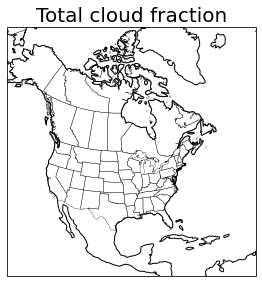

In [35]:
###########################################################################
l1 = 0.02; l2 = 0.26; l3 = 0.50 ;l4= 0.74                               ### 
h  = 0.23; w  = 0.23 # h = height, w = width of the subplots (fraction) ###
b  = 0.73            # b = bottom height                                ###
fs = 13              # Fontsize for titles                              ###
###########################################################################
norm_diff = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1) # Norm centered at 0
fig       = plt.figure(figsize=(15, 15), constrained_layout = True)

#########################################################                
###                ax_maps function inputs            ###
###            --------------------------------       ###
### 1. ax number (e.g., ax1, ax2...)                  ###
### 2. position in plot [l, b, w, h]                  ###
### 3. extent of domain GEM5                          ###
### 4. Title if theres one, None if not               ###
### 5. Longitude 2D array                             ###
### 6. Latitude 2D array                              ###
### 7. Data 2D array                                  ###
### 8. Colormap choice (e.g., 'viridis','jet' etc)    ###
### 9. vmin                                           ###
### 10.vmax                                           ###
### 11.Norm                                           ###
### 12.Plotting colorbar: True or False               ###
### 13.y position of colorbar if colorbar is True     ###
### 14.Bounds of colormap if colorbar is True         ###
#########################################################

CALIPSO_t = ax_maps(1 ,[l1, b, w, h],ext, 'Total cloud fraction',lon,lat,data_CALIPSO[0],cm, 0, 1, norm_maps, True ,0.73,bounds_maps)
CALIPSO_h = ax_maps(2 ,[l2, b, w, h],ext, 'High cloud fraction' ,lon,lat,data_CALIPSO[1],cm, 0, 1, norm_maps, False,None,None)
CALIPSO_m = ax_maps(3 ,[l3, b, w, h],ext, 'Mid cloud fraction'  ,lon,lat,data_CALIPSO[2],cm, 0, 1, norm_maps, False,None,None)
CALIPSO_l = ax_maps(4 ,[l4, b, w, h],ext, 'Low cloud fraction'  ,lon,lat,data_CALIPSO[3],cm, 0, 1, norm_maps, False,None,None)
b = 0.48 # y position of GEM5 plots
GEM5_t = ax_maps(5 ,[l1, b, w, h],ext, None,lon,lat,g_bias_t,c, -1, 1, norm_diff, True,0.48,bounds_diff)
GEM5_h = ax_maps(6 ,[l2, b, w, h],ext, None,lon,lat,g_bias_h,c, -1, 1, norm_diff, False,None,None)
GEM5_m = ax_maps(7 ,[l3, b, w, h],ext, None,lon,lat,g_bias_m,c, -1, 1, norm_diff, False,None,None)
GEM5_l = ax_maps(8 ,[l4, b, w, h],ext, None,lon,lat,g_bias_l,c, -1, 1, norm_diff, False,None,None)
b = 0.23 # y position of COSP plots
COSP_t = ax_maps(9 ,[l1, b, w, h],ext, None,lon,lat,c_bias_t,c, -1, 1, norm_diff, True,0.23,bounds_diff)
COSP_h = ax_maps(10,[l2, b, w, h],ext, None,lon,lat,c_bias_h,c, -1, 1, norm_diff, False,None,None)
COSP_m = ax_maps(11,[l3, b, w, h],ext, None,lon,lat,c_bias_m,c, -1, 1, norm_diff, False,None,None)
COSP_l = ax_maps(12,[l4, b, w, h],ext, None,lon,lat,c_bias_l,c, -1, 1, norm_diff, False,None,None)

plt.annotate('CALIPSO'  , xy=(0.002, 0.79) , xycoords='figure fraction', rotation = 90, fontsize=20)
plt.annotate('CRCM6 Bias', xy=(0.002, 0.475), xycoords='figure fraction', rotation = 90, fontsize=20)
plt.annotate('COSP2(CRCM6) Bias', xy=(0.002, 0.14), xycoords='figure fraction', rotation = 90, fontsize=20)

x1 = 0.0295; x2 = 0.26; x3 = 0.49; x4 = 0.7205
y1 = 0.947; y2 = 0.655; y3 = 0.363

plt.annotate( 'a)',  xy=(x1, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
plt.annotate( 'b)',  xy=(x2, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
plt.annotate( 'c)',  xy=(x3, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
plt.annotate( 'd)',  xy=(x4, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

plt.annotate( 'e)',  xy=(x1, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
plt.annotate( 'f)',  xy=(x2, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
plt.annotate( 'g)',  xy=(x3, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
plt.annotate( 'h)',  xy=(x4, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

plt.annotate( 'i)',  xy=(x1, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
plt.annotate( 'j)',  xy=(x2, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
plt.annotate( 'k)',  xy=(x3, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
plt.annotate( 'l)',  xy=(x4, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

# Adjust the layout and display the plot
plt.tight_layout()
#plt.savefig('Figures/Cloudmaps/Bias/{}_{}_GEM5vsCOSPvsCALIPSO_bias_{}-{}.png'.format(period,layerdef,str(YYYYi),str(YYYYf)), format = 'png',bbox_inches = 'tight')
plt.show()

# RELATIVE ERROR maps

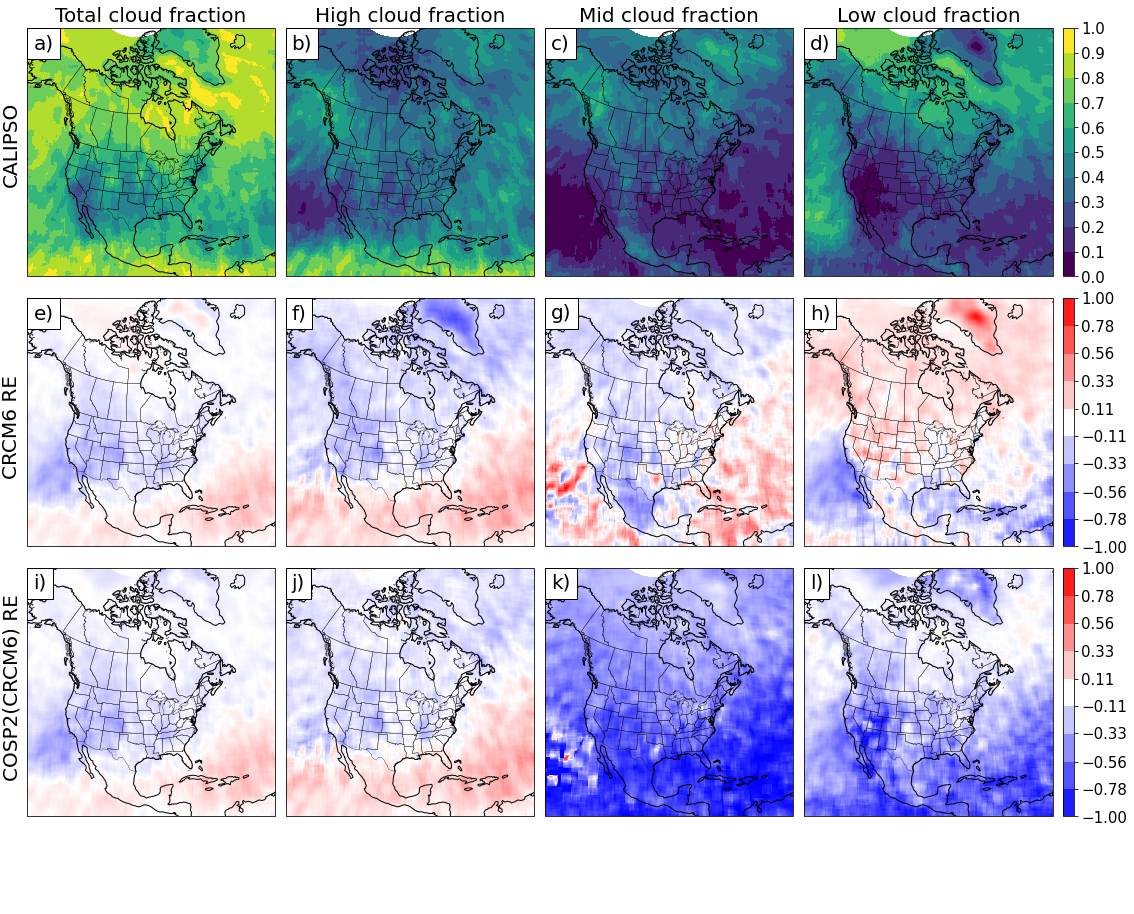

In [83]:
import matplotlib.cm as CM
import matplotlib.colors as mcolors


fig = plt.figure(figsize=(15, 15), constrained_layout = True)
vext = [0,1]
##########################################################################################################
###                                    Creating a discrete colorbar                                    ###
##########################################################################################################
# define the colormap                                                                                  ###
cmap_maps     = plt.cm.viridis                                                                         ###
# extract all colors from the .jet map                                                                 ###
cmaplist_maps = [cmap_maps(i) for i in range(cmap_maps.N)]                                             ###
# Colormap                                                                                             ###
cm            = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_maps, cmap_maps.N)###
# Colobar with values from 0 to 1 with 11 discrete colors                                              ###
bounds_maps  = np.linspace(0, 1, 11)                                                                   ###                                                                                            ###
norm_maps    = mpl.colors.BoundaryNorm(bounds_maps, cmap_maps.N) 
         ####################################################################################
# Bias colormap
# Define the custom colormap
colors = ['blue', 'white', 'red']
cmap_BWR = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define the normalization to center white at 0
norm_BWR = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
num = 10
# Create a colorbar with discrete intervals
bounds_BWR = np.linspace(-1, 1, num=num)  # 6 intervals between -1 and 1
ticks_BWR = bounds_BWR
##########################################################################################################

L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
#############################
###        MODIS          ###
#############################

###########################################################################
l1 = 0.02; l2 = 0.26; l3 = 0.50 ;l4= 0.74                               ### 
h  = 0.23; w  = 0.23 # h = height, w = width of the subplots (fraction) ###
b  = 0.73            # b = bottom height                                ###
fs = 13              # Fontsize for titles                              ###
###########################################################################
# First subplot
ax1 = plt.axes([l1, b, w, h],projection=m)
ax1.set_extent([xll, xur, yll, yur], crs = m)
ax1.set_title('Total cloud fraction', fontsize = 20)
ax1.coastlines()
ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
CALIPSO_t = ax1.pcolormesh(lon, lat,data_CALIPSO[0], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Second subplot
ax2 = plt.axes([l2, b, w, h],projection=m)
ax2.set_extent([xll, xur, yll, yur], crs = m)
ax2.set_title('High cloud fraction', fontsize = 20)
ax2.coastlines()
ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax2.pcolormesh(lon, lat,data_CALIPSO[1], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Third subplot
ax3 = plt.axes([l3, b, w, h],projection=m)
ax3.set_extent([xll, xur, yll, yur], crs = m)
ax3.set_title('Mid cloud fraction', fontsize = 20)
ax3.coastlines()
ax3.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax3.pcolormesh(lon, lat,data_CALIPSO[2], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Fourth subplot
ax4 = plt.axes([l4, b, w, h],projection=m)
ax4.set_extent([xll, xur, yll, yur], crs = m)
ax4.set_title('Low cloud fraction', fontsize = 20)
ax4.coastlines()
ax4.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax4.pcolormesh(lon, lat,data_CALIPSO[3], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

###########################
###         GEM5        ###
###########################
b = 0.48
# First subplot
ax5 = plt.axes([l1, b, w, h],projection=m)
ax5.set_extent([xll, xur, yll, yur], crs = m)
#ax5.set_title('Total Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax5.coastlines()
ax5.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
GEM_t = ax5.pcolormesh(lon, lat,g_RE_t, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Second subplot
ax6 = plt.axes([l2, b, w, h],projection=m)
ax6.set_extent([xll, xur, yll, yur], crs = m)
#ax6.set_title('High Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax6.coastlines()
ax6.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax6.pcolormesh(lon, lat,g_RE_h, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Third subplot
ax7 = plt.axes([l3, b, w, h],projection=m)
ax7.set_extent([xll, xur, yll, yur], crs = m)
#ax7.set_title('Mid Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax7.coastlines()
ax7.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax7.pcolormesh(lon, lat,g_RE_m, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Fourth subplot
ax8 = plt.axes([l4, b, w, h],projection=m)
ax8.set_extent([xll, xur, yll, yur], crs = m)
#ax8.set_title('Low Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax8.coastlines()
ax8.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax8.pcolormesh(lon, lat,g_RE_l, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

###########################
###        COSP2        ###
###########################
b = 0.23
# First subplot
ax9 = plt.axes([l1, b, w, h],projection=m)
ax9.set_extent([xll, xur, yll, yur], crs = m)
#ax9.set_title('Total Cloud Cover \n MODIS - CALIPSO',fontsize = 15)
ax9.coastlines()
ax9.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
COSP_t = ax9.pcolormesh(lon, lat, c_RE_t, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Second subplot
ax10 = plt.axes([l2, b, w, h],projection=m)
ax10.set_extent([xll, xur, yll, yur], crs = m)
#ax10.set_title('High Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax10.coastlines()
ax10.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax10.pcolormesh(lon, lat, c_RE_h, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Third subplot
ax11 = plt.axes([l3, b, w, h],projection=m)
ax11.set_extent([xll, xur, yll, yur], crs = m)
#ax11.set_title('Mid Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax11.coastlines()
ax11.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax11.pcolormesh(lon, lat, c_RE_m, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Fourth subplot
ax12 = plt.axes([l4, b, w, h],projection=m)
ax12.set_extent([xll, xur, yll, yur], crs = m)
#ax12.set_title('Low Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax12.coastlines()
ax12.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax12.pcolormesh(lon, lat, c_RE_l, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

#############################
###   Colorbar setting    ###
#############################
cb_l = 0.98
W    = 0.01
H    = 0.23
#Colorbar             # [left,bottom,width,height]
cbar_ax1 = fig.add_axes([cb_l, 0.73, W, H])
cbar1    = fig.colorbar(CALIPSO_t, extend = 'neither', cax = cbar_ax1, ticks=bounds_maps, boundaries=bounds_maps)
cbar1.ax.tick_params(labelsize=15)

cbar_ax2 = fig.add_axes([cb_l, 0.48, W, H])
cbar2 = fig.colorbar(CM.ScalarMappable(norm = norm_BWR, cmap = cmap_BWR),cax = cbar_ax2,boundaries = bounds_BWR, ticks=np.round(ticks_BWR,2))
cbar2.ax.tick_params(labelsize=15)

cbar_ax3 = fig.add_axes([cb_l, 0.23, W, H])
cbar3 = fig.colorbar(CM.ScalarMappable(norm = norm_BWR, cmap = cmap_BWR),cax = cbar_ax3,boundaries = bounds_BWR, ticks=np.round(ticks_BWR,2))
cbar3.ax.tick_params(labelsize=15)

ax1.annotate('CALIPSO',         xy=(0.002, 0.8), xycoords='figure fraction', rotation = 90, fontsize=20)
ax5.annotate('CRCM6 RE' ,       xy=(0.002, 0.48), xycoords='figure fraction', rotation = 90, fontsize=20)
ax5.annotate('COSP2(CRCM6) RE', xy=(0.002, 0.15), xycoords='figure fraction', rotation = 90, fontsize=20)

x1 = 0.0295; x2 = 0.257; x3 = 0.486; x4 = 0.714
y1 = 0.946; y2 = 0.651 ;y3 = 0.356
ax1.annotate( 'a)',  xy=(x1, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax2.annotate( 'b)',  xy=(x2, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax3.annotate( 'c)',  xy=(x3, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax4.annotate( 'd)',  xy=(x4, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax5.annotate( 'e)',  xy=(x1, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax6.annotate( 'f)',  xy=(x2, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax7.annotate( 'g)',  xy=(x3, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax8.annotate( 'h)',  xy=(x4, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax9.annotate( 'i)',  xy=(x1, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax10.annotate('j)',  xy=(x2, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax11.annotate('k)',  xy=(x3, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax12.annotate('l)',  xy=(x4, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('Figures/Cloudmaps/RE/{}_{}_GEM5vsCOSPvsCALIPSO_RE_{}-{}.png'.format(period,layerdef,str(YYYYi),str(YYYYf)), format = 'png',bbox_inches = 'tight')
plt.show()

# Bias maps

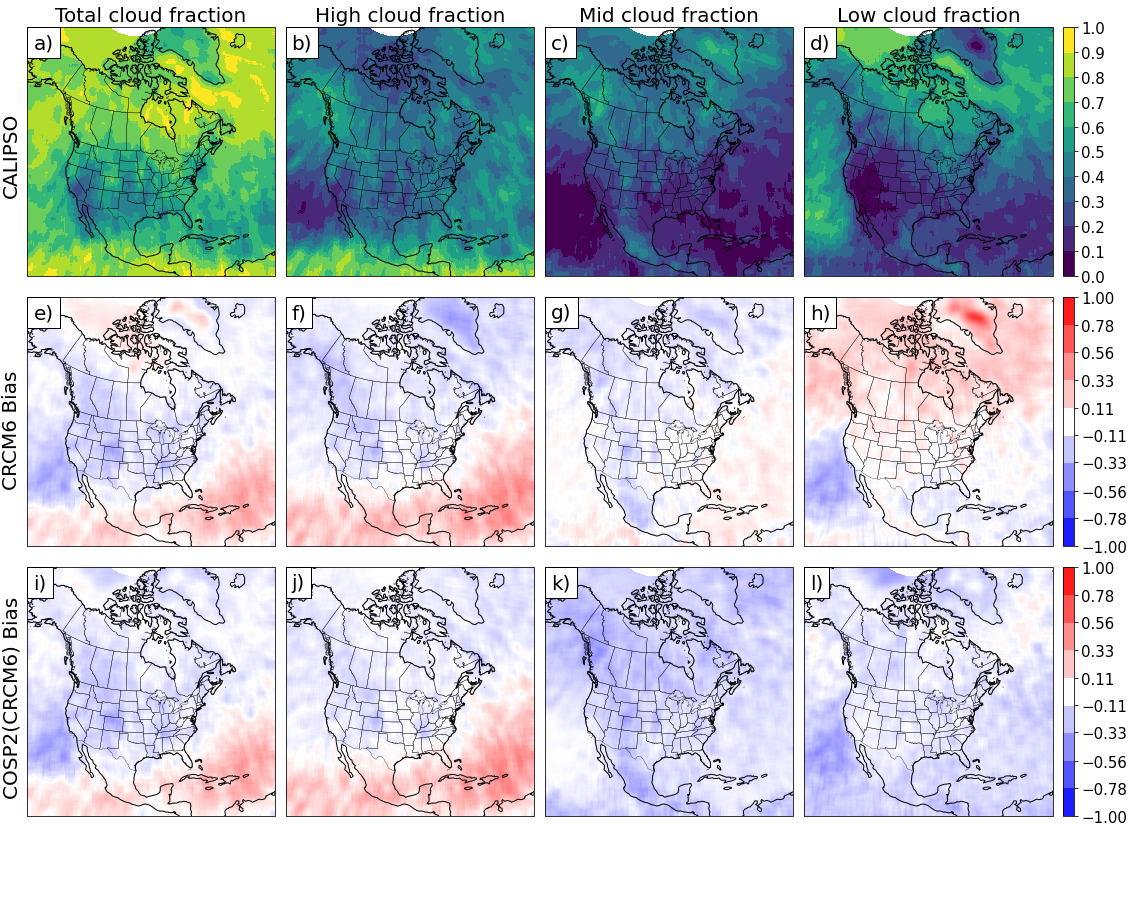

In [84]:
import matplotlib.cm as CM
import matplotlib.colors as mcolors


fig = plt.figure(figsize=(15, 15), constrained_layout = True)
vext = [0,1]
##########################################################################################################
###                                    Creating a discrete colorbar                                    ###
##########################################################################################################
# define the colormap                                                                                  ###
cmap_maps     = plt.cm.viridis                                                                         ###
# extract all colors from the .jet map                                                                 ###
cmaplist_maps = [cmap_maps(i) for i in range(cmap_maps.N)]                                             ###
# Colormap                                                                                             ###
cm            = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_maps, cmap_maps.N)###
# Colobar with values from 0 to 1 with 11 discrete colors                                              ###
bounds_maps  = np.linspace(0, 1, 11)                                                                   ###                                                                                            ###
norm_maps    = mpl.colors.BoundaryNorm(bounds_maps, cmap_maps.N) 
         ####################################################################################
# Bias colormap
# Define the custom colormap
colors = ['blue', 'white', 'red']
cmap_BWR = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

# Define the normalization to center white at 0
norm_BWR = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
num = 10
# Create a colorbar with discrete intervals
bounds_BWR = np.linspace(-1, 1, num=num)  # 6 intervals between -1 and 1
ticks_BWR = bounds_BWR
##########################################################################################################

L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
#############################
###        MODIS          ###
#############################

###########################################################################
l1 = 0.02; l2 = 0.26; l3 = 0.50 ;l4= 0.74                               ### 
h  = 0.23; w  = 0.23 # h = height, w = width of the subplots (fraction) ###
b  = 0.73            # b = bottom height                                ###
fs = 13              # Fontsize for titles                              ###
###########################################################################
# First subplot
ax1 = plt.axes([l1, b, w, h],projection=m)
ax1.set_extent([xll, xur, yll, yur], crs = m)
ax1.set_title('Total cloud fraction', fontsize = 20)
ax1.coastlines()
ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
CALIPSO_t = ax1.pcolormesh(lon, lat,data_CALIPSO[0], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Second subplot
ax2 = plt.axes([l2, b, w, h],projection=m)
ax2.set_extent([xll, xur, yll, yur], crs = m)
ax2.set_title('High cloud fraction', fontsize = 20)
ax2.coastlines()
ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax2.pcolormesh(lon, lat,data_CALIPSO[1], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Third subplot
ax3 = plt.axes([l3, b, w, h],projection=m)
ax3.set_extent([xll, xur, yll, yur], crs = m)
ax3.set_title('Mid cloud fraction', fontsize = 20)
ax3.coastlines()
ax3.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax3.pcolormesh(lon, lat,data_CALIPSO[2], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Fourth subplot
ax4 = plt.axes([l4, b, w, h],projection=m)
ax4.set_extent([xll, xur, yll, yur], crs = m)
ax4.set_title('Low cloud fraction', fontsize = 20)
ax4.coastlines()
ax4.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax4.pcolormesh(lon, lat,data_CALIPSO[3], cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

###########################
###         GEM5        ###
###########################
b = 0.48
# First subplot
ax5 = plt.axes([l1, b, w, h],projection=m)
ax5.set_extent([xll, xur, yll, yur], crs = m)
#ax5.set_title('Total Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax5.coastlines()
ax5.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
GEM_t = ax5.pcolormesh(lon, lat,g_bias_t, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Second subplot
ax6 = plt.axes([l2, b, w, h],projection=m)
ax6.set_extent([xll, xur, yll, yur], crs = m)
#ax6.set_title('High Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax6.coastlines()
ax6.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax6.pcolormesh(lon, lat,g_bias_h, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Third subplot
ax7 = plt.axes([l3, b, w, h],projection=m)
ax7.set_extent([xll, xur, yll, yur], crs = m)
#ax7.set_title('Mid Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax7.coastlines()
ax7.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax7.pcolormesh(lon, lat,g_bias_m, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Fourth subplot
ax8 = plt.axes([l4, b, w, h],projection=m)
ax8.set_extent([xll, xur, yll, yur], crs = m)
#ax8.set_title('Low Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax8.coastlines()
ax8.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax8.pcolormesh(lon, lat,g_bias_l, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

###########################
###        COSP2        ###
###########################
b = 0.23
# First subplot
ax9 = plt.axes([l1, b, w, h],projection=m)
ax9.set_extent([xll, xur, yll, yur], crs = m)
#ax9.set_title('Total Cloud Cover \n MODIS - CALIPSO',fontsize = 15)
ax9.coastlines()
ax9.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
COSP_t = ax9.pcolormesh(lon, lat, c_bias_t, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Second subplot
ax10 = plt.axes([l2, b, w, h],projection=m)
ax10.set_extent([xll, xur, yll, yur], crs = m)
#ax10.set_title('High Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax10.coastlines()
ax10.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax10.pcolormesh(lon, lat, c_bias_h, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Third subplot
ax11 = plt.axes([l3, b, w, h],projection=m)
ax11.set_extent([xll, xur, yll, yur], crs = m)
#ax11.set_title('Mid Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax11.coastlines()
ax11.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax11.pcolormesh(lon, lat, c_bias_m, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

# Fourth subplot
ax12 = plt.axes([l4, b, w, h],projection=m)
ax12.set_extent([xll, xur, yll, yur], crs = m)
#ax12.set_title('Low Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax12.coastlines()
ax12.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax12.pcolormesh(lon, lat, c_bias_l, cmap=cmap_BWR, vmin = -1, vmax = 1, transform=ccrs.PlateCarree(), norm = norm_BWR)

#############################
###   Colorbar setting    ###
#############################
cb_l = 0.98
W    = 0.01
H    = 0.23
#Colorbar             # [left,bottom,width,height]
cbar_ax1 = fig.add_axes([cb_l, 0.73, W, H])
cbar1    = fig.colorbar(CALIPSO_t, extend = 'neither', cax = cbar_ax1, ticks=bounds_maps, boundaries=bounds_maps)
cbar1.ax.tick_params(labelsize=15)

cbar_ax2 = fig.add_axes([cb_l, 0.48, W, H])
cbar2 = fig.colorbar(CM.ScalarMappable(norm = norm_BWR, cmap = cmap_BWR),cax = cbar_ax2,boundaries = bounds_BWR, ticks=np.round(ticks_BWR,2))
cbar2.ax.tick_params(labelsize=15)

cbar_ax3 = fig.add_axes([cb_l, 0.23, W, H])
cbar3 = fig.colorbar(CM.ScalarMappable(norm = norm_BWR, cmap = cmap_BWR),cax = cbar_ax3,boundaries = bounds_BWR, ticks=np.round(ticks_BWR,2))
cbar3.ax.tick_params(labelsize=15)

plt.annotate('CALIPSO'  , xy=(0.002, 0.79) , xycoords='figure fraction', rotation = 90, fontsize=20)
plt.annotate('CRCM6 Bias', xy=(0.002, 0.475), xycoords='figure fraction', rotation = 90, fontsize=20)
plt.annotate('COSP2(CRCM6) Bias', xy=(0.002, 0.14), xycoords='figure fraction', rotation = 90, fontsize=20)

x1 = 0.0295; x2 = 0.257; x3 = 0.486; x4 = 0.714
y1 = 0.947; y2 = 0.655; y3 = 0.363
ax1.annotate( 'a)',  xy=(x1, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax2.annotate( 'b)',  xy=(x2, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax3.annotate( 'c)',  xy=(x3, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax4.annotate( 'd)',  xy=(x4, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax5.annotate( 'e)',  xy=(x1, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax6.annotate( 'f)',  xy=(x2, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax7.annotate( 'g)',  xy=(x3, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax8.annotate( 'h)',  xy=(x4, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax9.annotate( 'i)',  xy=(x1, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax10.annotate('j)',  xy=(x2, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax11.annotate('k)',  xy=(x3, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax12.annotate('l)',  xy=(x4, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('Figures/Cloudmaps/Bias/{}_{}_GEM5vsCOSPvsCALIPSO_bias_{}-{}.png'.format(period,layerdef,str(YYYYi),str(YYYYf)), format = 'png',bbox_inches = 'tight')
plt.show()

# RMS & BIAS BAR PLOT

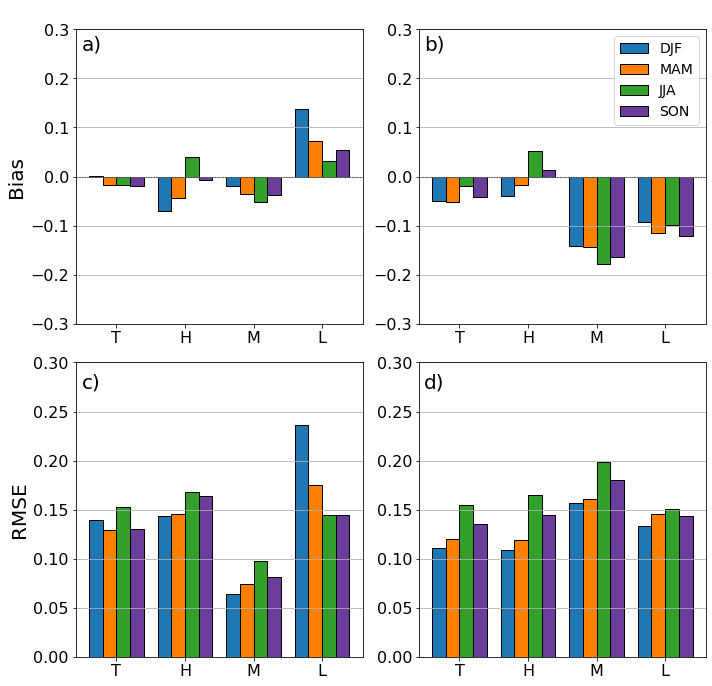

In [61]:
seasons = ['DJF', 'MAM', 'JJA', 'SON'] # Seasons
hatches = ['#1f78b4', '#ff7f00', '#33a02c', '#6a3d9a'] # colors associated with every season for color blind readers
x_ticks = ['T', 'H', 'M','L']  # x tick labels

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

bar_width = 0.2
for i, category in enumerate(seasons):

    x_positions = np.arange(len(x_ticks)) + i * bar_width
    # Bias
    ax[0,0].bar(x_positions, data_GEM5_bias [:, i], width=bar_width, label=category, color=hatches[i], edgecolor = 'k')
    ax[0,1].bar(x_positions, data_COSP_bias[:, i] , width=bar_width, label=category, color=hatches[i], edgecolor = 'k')
    # RMS
    ax[1,0].bar(x_positions, data_GEM5_rms[:, i]  , width=bar_width, label=category, color=hatches[i], edgecolor='k')
    ax[1,1].bar(x_positions, data_COSP_rms[:, i]  , width=bar_width, label=category, color=hatches[i], edgecolor='k')

# Set x tick positions and labels
for i in range(2):
    for j in range(2):
        if i == 1:
            ax[i,j].set_ylim(0,.3)
            #ax[i,j].set_yticklabels(np.round(np.arange(0,.35,0.05),2),fontsize = 16)
            ax[i,j].tick_params(axis='y', labelsize=16)

        else:
            ax[i,j].set_ylim(-0.3, 0.3)
            ax[i,j].tick_params(axis='y', labelsize=16)
        # Common to all subplots
        ax[i,j].set_xticks(np.arange(len(x_ticks)) + bar_width * (len(seasons) - 1) / 2)
        ax[i,j].set_xticklabels(x_ticks,fontsize = 16)
        ax[i,j].axhline(y = 0, color='k',linewidth = 0.5,  linestyle = '--')
        ax[i,j].grid(axis = 'y')
# Add legend
ax[0,1].legend(loc = 'upper right',prop = { "size": 14 })

ax[0,0].annotate('a)', xy=(.115, .948),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[0,1].annotate('b)', xy=(.595, .948),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[1,0].annotate('c)', xy=(.115, .455),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[1,1].annotate('d)', xy=(.595, .455),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[0,0].set_ylabel('Bias', fontsize = 20)
ax[1,0].set_ylabel('RMSE' , fontsize = 20)

plt.tight_layout()
plt.show()

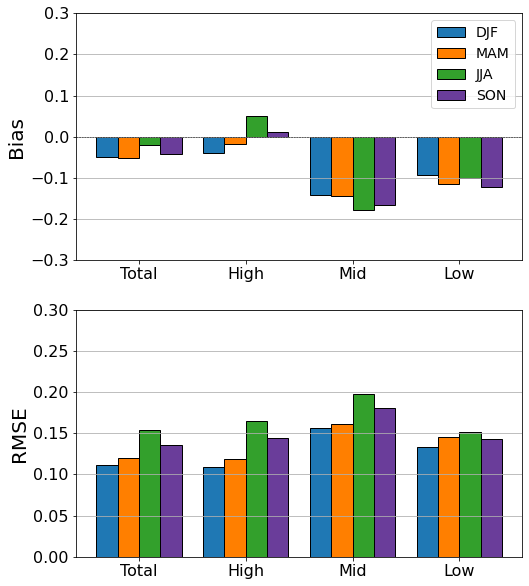

In [62]:
seasons = ['DJF', 'MAM', 'JJA', 'SON'] # Seasons
hatches = ['#1f78b4', '#ff7f00', '#33a02c', '#6a3d9a'] # colors associated with every season for color blind readers
x_ticks = ['Total', 'High', 'Mid','Low']  # x tick labels

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (8,10))

bar_width = 0.2
for i, category in enumerate(seasons):
    x_positions = np.arange(len(x_ticks)) + i * bar_width
    # Bias
    ax[0].bar(x_positions, data_COSP_bias[:, i] , width=bar_width, label=category, color=hatches[i], edgecolor = 'k')
    # RMS
    ax[1].bar(x_positions, data_COSP_rms[:, i]  , width=bar_width, label=category, color=hatches[i], edgecolor='k')

# Set x tick positions and labels
for i in range(2):
    if i == 1:
        ax[i].set_ylim(0,.3)
        ax[i].tick_params(axis='y', labelsize=16)
    else:
        ax[i].set_ylim(-0.3, 0.3)
        ax[i].tick_params(axis='y', labelsize=16)
    # Common to all subplots
    ax[i].set_xticks(np.arange(len(x_ticks)) + bar_width * (len(seasons) - 1) / 2)
    ax[i].set_xticklabels(x_ticks,fontsize = 16)
    ax[i].axhline(y = 0, color='k',linewidth = 0.5,  linestyle = '--')
    ax[i].grid(axis = 'y')
        
ax[0].set_ylabel('Bias', fontsize = 20)
ax[1].set_ylabel('RMSE' , fontsize = 20)

ax[0].legend(loc = 'upper right',prop = { "size": 14 })

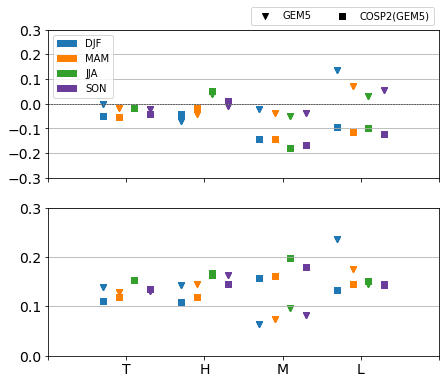

In [42]:
C_RMS = data_COSP_rms
G_RMS = data_GEM5_rms
C_BIA = data_COSP_bias
G_BIA = data_GEM5_bias

seasons = ['DJF', 'MAM', 'JJA', 'SON'] # Seasons
cloud_category = ['T', 'H', 'M','L']
hatches = ['#1f78b4', '#ff7f00', '#33a02c', '#6a3d9a']
x_ticks = ['','T', 'H', 'M','L','']
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (7,6), sharex = True)


bar_width = 0.2
for i, season in enumerate(seasons):
    for j, cloud in enumerate(cloud_category):
        x_positions = np.arange(len(x_ticks)) + j * bar_width - 0.3
    
        ax[0].scatter(x_positions[1], C_BIA[0][j],marker = 's', color=hatches[j])
        ax[0].scatter(x_positions[2], C_BIA[1][j],marker = 's', color=hatches[j])
        ax[0].scatter(x_positions[3], C_BIA[2][j],marker = 's', color=hatches[j])
        ax[0].scatter(x_positions[4], C_BIA[3][j],marker = 's', color=hatches[j])
        
        ax[0].scatter(x_positions[1], G_BIA[0][j],marker = 'v', color=hatches[j])
        ax[0].scatter(x_positions[2], G_BIA[1][j],marker = 'v', color=hatches[j])
        ax[0].scatter(x_positions[3], G_BIA[2][j],marker = 'v', color=hatches[j])
        ax[0].scatter(x_positions[4], G_BIA[3][j],marker = 'v', color=hatches[j])
        
        ax[1].scatter(x_positions[1], C_RMS[0][j],marker = 's', color=hatches[j])
        ax[1].scatter(x_positions[2], C_RMS[1][j],marker = 's', color=hatches[j])
        ax[1].scatter(x_positions[3], C_RMS[2][j],marker = 's', color=hatches[j])
        ax[1].scatter(x_positions[4], C_RMS[3][j],marker = 's', color=hatches[j])
        
        ax[1].scatter(x_positions[1], G_RMS[0][j],marker = 'v', color=hatches[j])
        ax[1].scatter(x_positions[2], G_RMS[1][j],marker = 'v', color=hatches[j])
        ax[1].scatter(x_positions[3], G_RMS[2][j],marker = 'v', color=hatches[j])
        ax[1].scatter(x_positions[4], G_RMS[3][j],marker = 'v', color=hatches[j])

ax[0].bar(7,0.4,linestyle = None,color = hatches[0], label = 'DJF')
ax[0].bar(7,0.4,color = hatches[1], label = 'MAM')
ax[0].bar(7,0.4,color = hatches[2], label = 'JJA')
ax[0].bar(7,0.4,color = hatches[3], label = 'SON')
ax[0].legend(loc = 'upper left')
    
ax[1].scatter(7,14,marker = 'v',color = 'k', label = 'GEM5')
ax[1].scatter(7,15,marker = 's',color = 'k', label = 'COSP2(GEM5)')
ax[1].legend(loc = 'lower right', ncol = 2, bbox_to_anchor = (1,2.2))

for i in range(2):
    if i == 1:
        ax[i].set_ylim(0,.3)
        ax[i].set_xlim(0,5)
        ax[i].tick_params(axis='y', labelsize=14)
    else:
        ax[i].set_ylim(-0.3, 0.3)
        ax[i].set_xlim(0,5)
        ax[i].set_yticks(np.arange(-0.3,0.4,0.1))
        ax[i].tick_params(axis='y', labelsize=14)
    # Common to all subplots
    ax[i].set_xticks(np.arange(0,6))
    ax[i].set_xticklabels(x_ticks,fontsize = 14)
    ax[i].axhline(y = 0, color='k',linewidth = 0.5,  linestyle = '--')
    ax[i].grid(axis = 'y')
    
plt.show()